# AI vs Human Writing Detection - Exploratory Data Analysis

**Updated for new high-quality dataset (788k samples)**

This notebook provides comprehensive analysis of the AI detection dataset including:
- Class distribution
- Text length analysis
- Vocabulary analysis
- Sample text inspection
- Feature correlations

## Setup and Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import Counter
import re
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (15, 6)
plt.rcParams['font.size'] = 11

# Create output directory
output_dir = Path('results/eda')
output_dir.mkdir(parents=True, exist_ok=True)

print("✓ Setup complete!")

✓ Setup complete!


## 1. Load Dataset

In [ ]:
# Try to load cleaned dataset first, fallback to original
from pathlib import Path

# Detect if running from notebooks/ or root
if Path('notebooks').exists():
    # Running from root
    data_prefix = ''
    output_prefix = ''
else:
    # Running from notebooks/
    data_prefix = '../'
    output_prefix = '../'

# Create output directory
output_dir = Path(f'{output_prefix}results/eda')
output_dir.mkdir(parents=True, exist_ok=True)

# Load dataset
cleaned_path = Path(f'{data_prefix}data/raw/cleaned_ai_human_15k.csv')
original_path = Path(f'{data_prefix}data/raw/cleaned_ai_human_15k.csv')

if cleaned_path.exists():
    df = pd.read_csv(cleaned_path)
    print(f"✓ Loaded CLEANED dataset: {len(df):,} samples")
else:
    df = pd.read_csv(original_path)
    print(f"✓ Loaded ORIGINAL dataset: {len(df):,} samples")
    
    # Quick preprocessing
    text_col = None
    for col in ['text', 'content', 'essay', 'text_content']:
        if col in df.columns:
            text_col = col
            break
    
    label_col = None
    for col in ['source', 'label', 'model']:
        if col in df.columns:
            label_col = col
            break
    
    if text_col and label_col:
        df['text_content'] = df[text_col]
        df['model_name'] = df[label_col]
        df['label'] = df[label_col].apply(
            lambda x: 0 if str(x).lower() in ['human', 'humans'] else 1
        )

print(f"\n📊 Dataset Info:")
print(f"   Shape: {df.shape}")
print(f"   Columns: {df.columns.tolist()}")
print(f"   Memory: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

✓ Loaded CLEANED dataset: 50,000 samples

📊 Dataset Info:
   Shape: (50000, 3)
   Columns: ['text_content', 'label', 'model_name']
   Memory: 246.71 MB


In [8]:
# Display first few rows
df.head()

,text_content,label,model_name
0,"\nIn the quaint town of Willow Creek, nestled ...",1,YI-34B
1,Telstra: Internet and Mobile Phone Services Ma...,0,Human
2,I think that the face is just a natural landfo...,0,Human
3,"Movies, except for digital ones, have been sho...",0,Human
4,Title: The Benefits of a School Program That P...,1,Mistral-7B


In [9]:
# Check for missing values
print("Missing Values:")
missing = df.isnull().sum()
if missing.sum() > 0:
    print(missing[missing > 0])
else:
    print("✓ No missing values!")

# Check for duplicates
duplicates = df.duplicated().sum()
print(f"\nDuplicates: {duplicates:,} ({duplicates/len(df)*100:.2f}%)")

Missing Values:
✓ No missing values!

Duplicates: 0 (0.00%)


## 2. Class Distribution

In [10]:
# Binary class distribution
print("🏷️  Binary Labels (AI vs Human):")
label_counts = df['label'].value_counts().sort_index()
for label, count in label_counts.items():
    label_name = "Human" if label == 0 else "AI"
    print(f"   {label_name} ({label}): {count:,} ({count/len(df)*100:.1f}%)")

🏷️  Binary Labels (AI vs Human):
   Human (0): 25,000 (50.0%)
   AI (1): 25,000 (50.0%)


In [11]:
# Model/source distribution
if 'model_name' in df.columns:
    print("\n🤖 Model Distribution:")
    model_counts = df['model_name'].value_counts()
    print(f"   Unique sources: {len(model_counts)}")
    print(f"\n   Top 15 sources:")
    for i, (model, count) in enumerate(model_counts.head(15).items(), 1):
        print(f"   {i:2d}. {model:30s}: {count:7,} ({count/len(df)*100:.1f}%)")
    
    if len(model_counts) > 15:
        print(f"   ... and {len(model_counts) - 15} more sources")


🤖 Model Distribution:
   Unique sources: 63

   Top 15 sources:
    1. Human                         :  25,000 (50.0%)
    2. GPT-3.5                       :   2,863 (5.7%)
    3. Text-Davinci-003              :   1,255 (2.5%)
    4. Text-Davinci-002              :   1,156 (2.3%)
    5. OPT-1.3B                      :   1,003 (2.0%)
    6. OPT-30B                       :     976 (2.0%)
    7. Nous-Hermes-LLaMA-2-13B       :     689 (1.4%)
    8. LLaMA-7B                      :     584 (1.2%)
    9. LLaMA-65B                     :     569 (1.1%)
   10. Mistral-7B                    :     566 (1.1%)
   11. OPT-2.7B                      :     563 (1.1%)
   12. LLaMA-13B                     :     554 (1.1%)
   13. Flan-T5-Base                  :     552 (1.1%)
   14. OPT-350M                      :     543 (1.1%)
   15. OPT-6.7B                      :     538 (1.1%)
   ... and 48 more sources


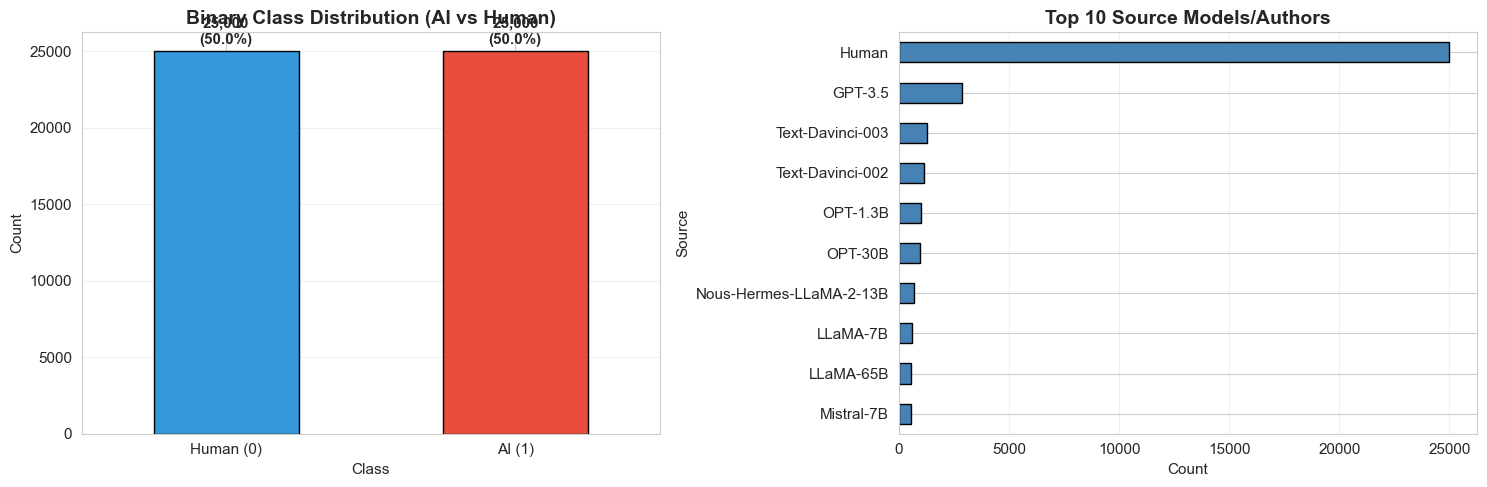

✓ Saved: ../results/eda/01_class_distribution.png


In [12]:
# Visualize class distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Binary distribution
ax1 = axes[0]
label_counts.plot(kind='bar', ax=ax1, color=['#3498db', '#e74c3c'], edgecolor='black')
ax1.set_title('Binary Class Distribution (AI vs Human)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Class')
ax1.set_ylabel('Count')
ax1.set_xticklabels(['Human (0)', 'AI (1)'], rotation=0)
ax1.grid(axis='y', alpha=0.3)
for i, v in enumerate(label_counts):
    ax1.text(i, v + len(df)*0.01, f'{v:,}\n({v/len(df)*100:.1f}%)', 
             ha='center', fontweight='bold')

# Model distribution (top 10)
if 'model_name' in df.columns:
    ax2 = axes[1]
    top_models = df['model_name'].value_counts().head(10)
    top_models.plot(kind='barh', ax=ax2, color='steelblue', edgecolor='black')
    ax2.set_title('Top 10 Source Models/Authors', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Count')
    ax2.set_ylabel('Source')
    ax2.invert_yaxis()
    ax2.grid(axis='x', alpha=0.3)
else:
    axes[1].axis('off')

plt.tight_layout()
plt.savefig(output_dir / '01_class_distribution.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"✓ Saved: {output_dir / '01_class_distribution.png'}")

## 3. Text Length Analysis

In [13]:
# Calculate text statistics
df['text_length'] = df['text_content'].str.len()
df['word_count'] = df['text_content'].str.split().str.len()
df['avg_word_length'] = df['text_length'] / df['word_count']
df['sentence_count'] = df['text_content'].str.count(r'[.!?]+')

print("📏 Text Statistics (All Samples):")
stats = df[['text_length', 'word_count', 'avg_word_length', 'sentence_count']].describe()
print(stats)

📏 Text Statistics (All Samples):
         text_length    word_count  avg_word_length  sentence_count
count   50000.000000  50000.000000     50000.000000    50000.000000
mean     3286.119740    523.731740         6.019344       31.724520
std      4977.250542    732.267165         0.702969       48.770549
min       113.000000     25.000000         3.192140        0.000000
25%       674.000000    115.000000         5.545455        6.000000
50%      1965.000000    332.000000         5.998418       18.000000
75%      3992.000000    640.000000         6.448072       34.000000
max    252713.000000  23321.000000        43.384770     1506.000000


In [14]:
# Statistics by class
print("\n📏 Text Statistics by Class:")
for label in [0, 1]:
    label_name = "Human" if label == 0 else "AI"
    print(f"\n{label_name} (label={label}):")
    class_stats = df[df['label'] == label][['text_length', 'word_count', 'avg_word_length']].describe()
    print(class_stats)


📏 Text Statistics by Class:

Human (label=0):
         text_length    word_count  avg_word_length
count   25000.000000  25000.000000     25000.000000
mean     4516.775840    717.230320         5.995462
std      6591.693167    960.480806         0.731349
min       113.000000     25.000000         4.164234
25%       906.000000    155.000000         5.542136
50%      2319.000000    401.000000         5.980392
75%      5488.250000    897.000000         6.389946
max    252713.000000  23321.000000        43.384770

AI (label=1):
        text_length    word_count  avg_word_length
count  25000.000000  25000.000000     25000.000000
mean    2055.463640    330.233160         6.043225
std     1751.418861    273.938088         0.672561
min      119.000000     25.000000         3.192140
25%      490.000000     85.000000         5.551004
50%     1645.000000    276.000000         6.018540
75%     3421.000000    535.000000         6.523031
max    38524.000000   7627.000000        28.833333


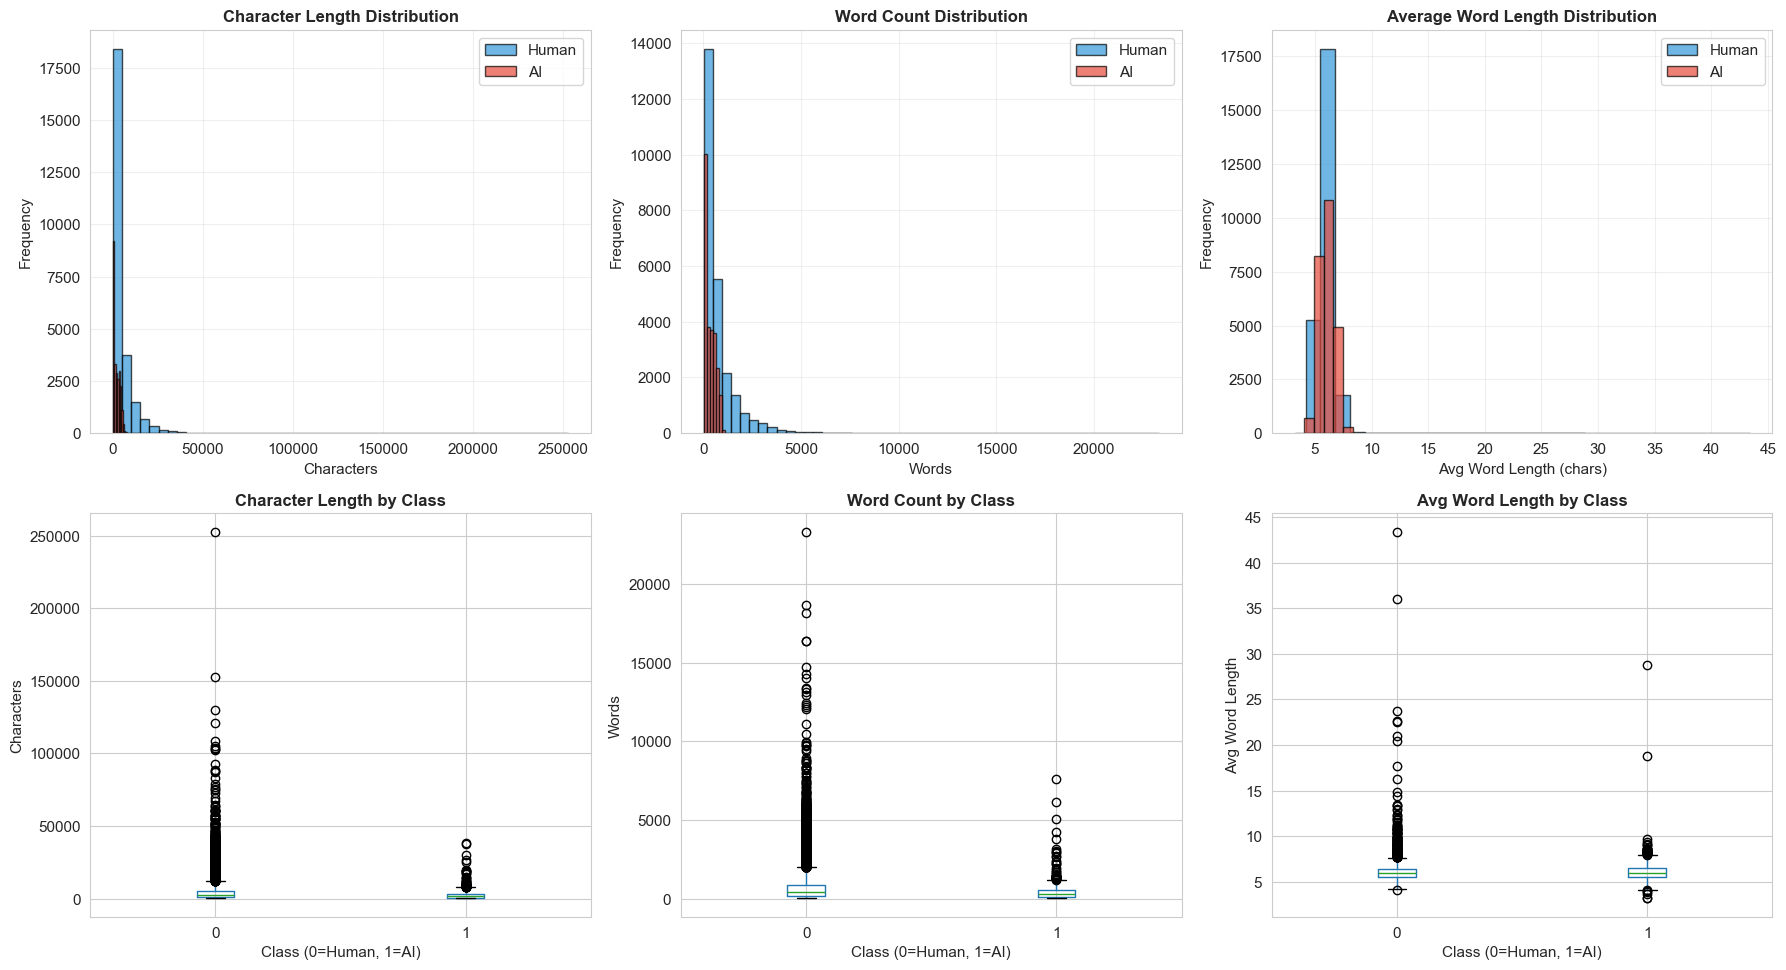

✓ Saved: ../results/eda/02_text_length_analysis.png


In [15]:
# Visualize text length distributions
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Character length distribution
ax1 = axes[0, 0]
df[df['label'] == 0]['text_length'].hist(bins=50, ax=ax1, alpha=0.7, label='Human', 
                                           color='#3498db', edgecolor='black')
df[df['label'] == 1]['text_length'].hist(bins=50, ax=ax1, alpha=0.7, label='AI', 
                                           color='#e74c3c', edgecolor='black')
ax1.set_title('Character Length Distribution', fontweight='bold', fontsize=12)
ax1.set_xlabel('Characters')
ax1.set_ylabel('Frequency')
ax1.legend()
ax1.grid(alpha=0.3)

# Word count distribution
ax2 = axes[0, 1]
df[df['label'] == 0]['word_count'].hist(bins=50, ax=ax2, alpha=0.7, label='Human', 
                                          color='#3498db', edgecolor='black')
df[df['label'] == 1]['word_count'].hist(bins=50, ax=ax2, alpha=0.7, label='AI', 
                                          color='#e74c3c', edgecolor='black')
ax2.set_title('Word Count Distribution', fontweight='bold', fontsize=12)
ax2.set_xlabel('Words')
ax2.set_ylabel('Frequency')
ax2.legend()
ax2.grid(alpha=0.3)

# Average word length distribution
ax3 = axes[0, 2]
df[df['label'] == 0]['avg_word_length'].hist(bins=30, ax=ax3, alpha=0.7, label='Human', 
                                               color='#3498db', edgecolor='black')
df[df['label'] == 1]['avg_word_length'].hist(bins=30, ax=ax3, alpha=0.7, label='AI', 
                                               color='#e74c3c', edgecolor='black')
ax3.set_title('Average Word Length Distribution', fontweight='bold', fontsize=12)
ax3.set_xlabel('Avg Word Length (chars)')
ax3.set_ylabel('Frequency')
ax3.legend()
ax3.grid(alpha=0.3)

# Box plots
ax4 = axes[1, 0]
df.boxplot(column='text_length', by='label', ax=ax4)
ax4.set_title('Character Length by Class', fontweight='bold', fontsize=12)
ax4.set_xlabel('Class (0=Human, 1=AI)')
ax4.set_ylabel('Characters')
ax4.get_figure().suptitle('')

ax5 = axes[1, 1]
df.boxplot(column='word_count', by='label', ax=ax5)
ax5.set_title('Word Count by Class', fontweight='bold', fontsize=12)
ax5.set_xlabel('Class (0=Human, 1=AI)')
ax5.set_ylabel('Words')
ax5.get_figure().suptitle('')

ax6 = axes[1, 2]
df.boxplot(column='avg_word_length', by='label', ax=ax6)
ax6.set_title('Avg Word Length by Class', fontweight='bold', fontsize=12)
ax6.set_xlabel('Class (0=Human, 1=AI)')
ax6.set_ylabel('Avg Word Length')
ax6.get_figure().suptitle('')

plt.tight_layout()
plt.savefig(output_dir / '02_text_length_analysis.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"✓ Saved: {output_dir / '02_text_length_analysis.png'}")

## 4. Vocabulary Analysis

In [16]:
def get_vocabulary_stats(texts, top_n=20):
    """Get vocabulary statistics from texts."""
    all_words = []
    for text in texts:
        words = re.findall(r'\b[a-zA-Z]+\b', str(text).lower())
        all_words.extend(words)
    
    word_counts = Counter(all_words)
    
    return {
        'total_words': len(all_words),
        'unique_words': len(word_counts),
        'vocabulary_richness': len(word_counts) / len(all_words) if all_words else 0,
        'top_words': word_counts.most_common(top_n)
    }

# Sample for faster computation
sample_size = min(10000, len(df))
df_sample = df.sample(sample_size, random_state=42)
print(f"⚙️  Analyzing vocabulary on {sample_size:,} sample texts...\n")

human_texts = df_sample[df_sample['label'] == 0]['text_content']
ai_texts = df_sample[df_sample['label'] == 1]['text_content']

human_vocab = get_vocabulary_stats(human_texts)
ai_vocab = get_vocabulary_stats(ai_texts)

print(f"📚 Vocabulary Statistics (on {sample_size:,} samples):")
print(f"\nHuman texts:")
print(f"   Total words: {human_vocab['total_words']:,}")
print(f"   Unique words: {human_vocab['unique_words']:,}")
print(f"   Vocabulary richness: {human_vocab['vocabulary_richness']:.4f}")

print(f"\nAI texts:")
print(f"   Total words: {ai_vocab['total_words']:,}")
print(f"   Unique words: {ai_vocab['unique_words']:,}")
print(f"   Vocabulary richness: {ai_vocab['vocabulary_richness']:.4f}")

⚙️  Analyzing vocabulary on 10,000 sample texts...

📚 Vocabulary Statistics (on 10,000 samples):

Human texts:
   Total words: 3,643,235
   Unique words: 62,261
   Vocabulary richness: 0.0171

AI texts:
   Total words: 1,652,720
   Unique words: 37,995
   Vocabulary richness: 0.0230


In [17]:
# Display top words
print(f"\nTop 10 words (Human):")
for word, count in human_vocab['top_words'][:10]:
    print(f"   {word}: {count:,}")

print(f"\nTop 10 words (AI):")
for word, count in ai_vocab['top_words'][:10]:
    print(f"   {word}: {count:,}")


Top 10 words (Human):
   the: 253,954
   of: 126,941
   to: 109,604
   and: 105,293
   in: 78,833
   a: 68,392
   is: 50,866
   that: 50,371
   for: 31,942
   it: 30,696

Top 10 words (AI):
   the: 89,021
   and: 57,369
   to: 50,708
   of: 50,254
   a: 36,052
   in: 28,334
   that: 18,721
   is: 18,053
   for: 16,521
   it: 15,165


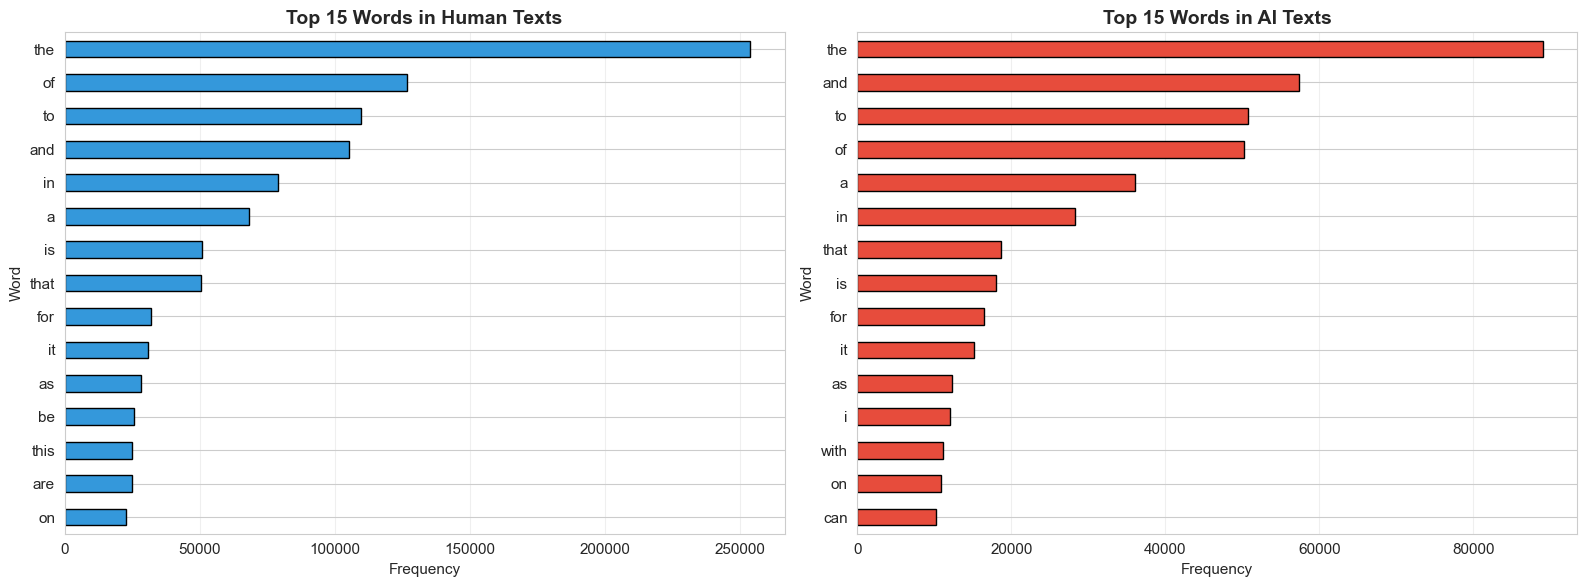

✓ Saved: ../results/eda/03_vocabulary_analysis.png


In [18]:
# Visualize top words comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Human top words
ax1 = axes[0]
human_top = pd.DataFrame(human_vocab['top_words'][:15], columns=['word', 'count'])
human_top.plot(kind='barh', x='word', y='count', ax=ax1, color='#3498db', 
               legend=False, edgecolor='black')
ax1.set_title('Top 15 Words in Human Texts', fontsize=14, fontweight='bold')
ax1.set_xlabel('Frequency')
ax1.set_ylabel('Word')
ax1.invert_yaxis()
ax1.grid(axis='x', alpha=0.3)

# AI top words
ax2 = axes[1]
ai_top = pd.DataFrame(ai_vocab['top_words'][:15], columns=['word', 'count'])
ai_top.plot(kind='barh', x='word', y='count', ax=ax2, color='#e74c3c', 
            legend=False, edgecolor='black')
ax2.set_title('Top 15 Words in AI Texts', fontsize=14, fontweight='bold')
ax2.set_xlabel('Frequency')
ax2.set_ylabel('Word')
ax2.invert_yaxis()
ax2.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig(output_dir / '03_vocabulary_analysis.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"✓ Saved: {output_dir / '03_vocabulary_analysis.png'}")

## 5. Sample Texts

In [19]:
# Display sample texts from each class
for label in [0, 1]:
    label_name = "Human" if label == 0 else "AI"
    samples = df[df['label'] == label].sample(3, random_state=42)
    
    print("=" * 70)
    print(f"{label_name.upper()} SAMPLES (label={label})")
    print("=" * 70)
    
    for i, (idx, row) in enumerate(samples.iterrows(), 1):
        print(f"\n[Sample {i}]")
        if 'model_name' in row:
            print(f"Source: {row['model_name']}")
        print(f"Length: {len(row['text_content'])} chars, {len(row['text_content'].split())} words")
        print(f"Text preview:\n{row['text_content'][:500]}...")
        print("-" * 70)

HUMAN SAMPLES (label=0)

[Sample 1]
Source: Human
Length: 3085 chars, 453 words
Text preview:
Risk and Capital Budgeting: Impacts and How to Mitigate Risks Essay

Table of Contents
 1. Introduction
 2. How Risk Impacts Capital Budgeting
 3. Mitigating Risk to Attract Investors
 4. Conclusion
 5. References

Introduction

The decision to fund a project may give rise to uncertainties; this forces a company to undertake the necessary research to understand its operating environment. Identifying corporate risk in capital budgeting is the most important aspect of project management. The level...
----------------------------------------------------------------------

[Sample 2]
Source: Human
Length: 3131 chars, 531 words
Text preview:
Assimilating Depression few years ago, I overheard my father pressing the psychiatrist about my mother's hospitalization for depression and I convinced myself that I, a naive child of twelve, would never "be crazy." Five years later, I was gazing at the name pl

## 6. Correlation Analysis

In [20]:
# Feature correlation matrix
numeric_features = ['text_length', 'word_count', 'avg_word_length', 'sentence_count', 'label']
corr_df = df[numeric_features].corr()

print("📊 Feature Correlations:")
print(corr_df)

print("\n📊 Correlation with Label (AI vs Human):")
label_corr = corr_df['label'].sort_values(ascending=False)
for feature, corr_val in label_corr.items():
    if feature != 'label':
        print(f"   {feature:20s}: {corr_val:+.4f}")

📊 Feature Correlations:
                 text_length  word_count  avg_word_length  sentence_count  \
text_length         1.000000    0.973816         0.357752        0.937014   
word_count          0.973816    1.000000         0.259540        0.940321   
avg_word_length     0.357752    0.259540         1.000000        0.241358   
sentence_count      0.937014    0.940321         0.241358        1.000000   
label              -0.247259   -0.264249         0.033972       -0.283193   

                    label  
text_length     -0.247259  
word_count      -0.264249  
avg_word_length  0.033972  
sentence_count  -0.283193  
label            1.000000  

📊 Correlation with Label (AI vs Human):
   avg_word_length     : +0.0340
   text_length         : -0.2473
   word_count          : -0.2642
   sentence_count      : -0.2832


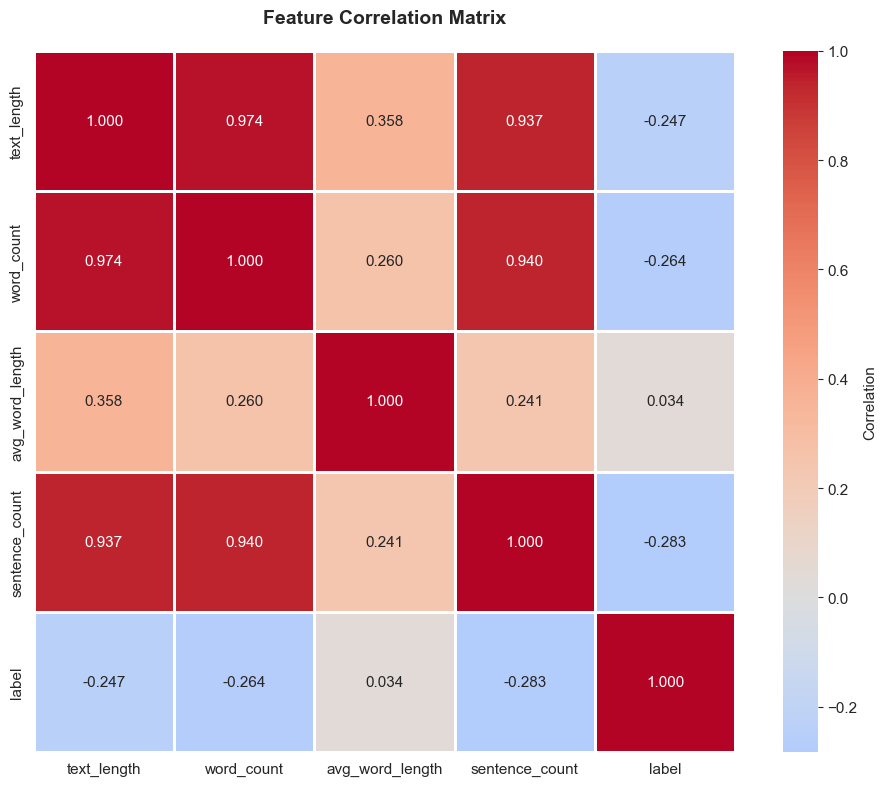

✓ Saved: ../results/eda/04_correlation_matrix.png


In [21]:
# Correlation heatmap
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_df, annot=True, fmt='.3f', cmap='coolwarm', center=0, 
            square=True, ax=ax, cbar_kws={'label': 'Correlation'},
            linewidths=1, linecolor='white')
ax.set_title('Feature Correlation Matrix', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig(output_dir / '04_correlation_matrix.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"✓ Saved: {output_dir / '04_correlation_matrix.png'}")

## 7. Summary Report

In [22]:
# Generate summary statistics table
summary = {
    'Metric': ['Total Samples', 'Human Samples', 'AI Samples', 
               'Unique Sources', 'Duplicates', 'Avg Text Length', 'Avg Word Count'],
    'Value': [
        f"{len(df):,}",
        f"{(df['label'] == 0).sum():,}",
        f"{(df['label'] == 1).sum():,}",
        f"{df['model_name'].nunique() if 'model_name' in df.columns else 'N/A'}",
        f"{df.duplicated().sum():,}",
        f"{df['text_length'].mean():.0f} chars",
        f"{df['word_count'].mean():.0f} words"
    ],
    'Percentage': [
        '100%',
        f"{(df['label'] == 0).sum()/len(df)*100:.1f}%",
        f"{(df['label'] == 1).sum()/len(df)*100:.1f}%",
        'N/A',
        f"{df.duplicated().sum()/len(df)*100:.2f}%",
        'N/A',
        'N/A'
    ]
}

summary_df = pd.DataFrame(summary)
summary_df.to_csv(output_dir / 'summary_statistics.csv', index=False)

print("📊 Summary Statistics:")
display(summary_df)
print(f"\n✓ Saved: {output_dir / 'summary_statistics.csv'}")

📊 Summary Statistics:


,Metric,Value,Percentage
0,Total Samples,"50,000",100%
1,Human Samples,"25,000",50.0%
2,AI Samples,"25,000",50.0%
3,Unique Sources,63,N/A
4,Duplicates,0,0.00%
5,Avg Text Length,3286 chars,N/A
6,Avg Word Count,524 words,N/A



✓ Saved: ../results/eda/summary_statistics.csv


## 8. Key Findings & Insights

In [23]:
print("=" * 70)
print("KEY FINDINGS")
print("=" * 70)

# Class balance
human_pct = (df['label'] == 0).sum() / len(df) * 100
ai_pct = (df['label'] == 1).sum() / len(df) * 100
print(f"\n1. CLASS BALANCE")
if abs(human_pct - 50) < 5:
    print(f"   ✅ EXCELLENT: Dataset is well-balanced ({human_pct:.1f}% Human, {ai_pct:.1f}% AI)")
elif abs(human_pct - 50) < 15:
    print(f"   ⚠️  ACCEPTABLE: Slight imbalance ({human_pct:.1f}% Human, {ai_pct:.1f}% AI)")
else:
    print(f"   ❌ IMBALANCED: Consider resampling ({human_pct:.1f}% Human, {ai_pct:.1f}% AI)")

# Text length
avg_length = df['text_length'].mean()
print(f"\n2. TEXT LENGTH")
if 200 <= avg_length <= 2000:
    print(f"   ✅ GOOD: Average length is {avg_length:.0f} chars (suitable for transformers)")
elif avg_length < 200:
    print(f"   ⚠️  SHORT: Average length is {avg_length:.0f} chars (might lack context)")
else:
    print(f"   ⚠️  LONG: Average length is {avg_length:.0f} chars (will be truncated to 512 tokens)")

# Vocabulary richness
if 'vocabulary_richness' in locals():
    print(f"\n3. VOCABULARY RICHNESS")
    print(f"   Human: {human_vocab['vocabulary_richness']:.4f}")
    print(f"   AI: {ai_vocab['vocabulary_richness']:.4f}")
    if human_vocab['vocabulary_richness'] > ai_vocab['vocabulary_richness']:
        print(f"   ✅ Human texts show higher vocabulary diversity (expected)")

# Data quality
missing_pct = df.isnull().sum().sum() / (len(df) * len(df.columns)) * 100
dup_pct = df.duplicated().sum() / len(df) * 100
print(f"\n4. DATA QUALITY")
if missing_pct < 1:
    print(f"   ✅ Missing values: {missing_pct:.2f}% (excellent)")
else:
    print(f"   ⚠️  Missing values: {missing_pct:.2f}% (consider cleaning)")
    
if dup_pct < 1:
    print(f"   ✅ Duplicates: {dup_pct:.2f}% (acceptable)")
else:
    print(f"   ⚠️  Duplicates: {dup_pct:.2f}% (consider deduplication)")

print("\n" + "=" * 70)
print("RECOMMENDATION")
print("=" * 70)
print("\n✅ Dataset appears ready for fine-tuning!")
print("\n🚀 Next steps:")
print("   1. Review the generated plots in results/eda/")
print("   2. Verify sample texts are coherent and well-labeled")
print("   3. Proceed to fine-tuning: python finetune_transformers_v2.py")

KEY FINDINGS

1. CLASS BALANCE
   ✅ EXCELLENT: Dataset is well-balanced (50.0% Human, 50.0% AI)

2. TEXT LENGTH
   ⚠️  LONG: Average length is 3286 chars (will be truncated to 512 tokens)

4. DATA QUALITY
   ✅ Missing values: 0.00% (excellent)
   ✅ Duplicates: 0.00% (acceptable)

RECOMMENDATION

✅ Dataset appears ready for fine-tuning!

🚀 Next steps:
   1. Review the generated plots in results/eda/
   2. Verify sample texts are coherent and well-labeled
   3. Proceed to fine-tuning: python finetune_transformers_v2.py


## Generated Files

This notebook generated the following files in `results/eda/`:
- `01_class_distribution.png` - Class balance visualization
- `02_text_length_analysis.png` - Text length distributions
- `03_vocabulary_analysis.png` - Top words comparison
- `04_correlation_matrix.png` - Feature correlations
- `summary_statistics.csv` - Key metrics table